# 0.0. IMPORTS

In [79]:
import math
import datetime
import inflection
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from boruta import BorutaPy
from tabulate import tabulate
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [83]:
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape, 
                          'RMSE': rmse }, index=[0] )

#############################################################################################

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values # matriz de confusao
    n = cm.sum() # soma de todos valores
    r, k = cm.shape # nº de linhas e colunas
    chi2 = stats.chi2_contingency(cm)[0] #teste qui² de pearson
    
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) ) # correcao qui²
    kcorr = k - (k-1)**2/(n-1) # correcao n colunas
    rcorr = r - (r-1)**2/(n-1) # correcao n linhas
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1) ) )

#############################################################################################

def jupyter_settings():
    #%matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [24, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings()

## 0.2. Loading Data

In [3]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. DESCRICAO DOS DADOS    

In [4]:
df1 = df_raw.copy() #copia

## 1.1. Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x ) # Função para converter os nomes das colunas para letras minúsculas e separadas por '_' 

cols_new = list( map( snakecase, cols_old ) ) # Faz o map com a função snakecase em todas as colunas cols_old (o list cria a nova lista com os nomes novos)

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [6]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) ) # primeiro elemento pega as linha [0]
print( 'Number of Cols: {}'.format( df1.shape[1] ) ) # segundo elemento pega as colunas [1]

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [7]:
df1['date'] = pd.to_datetime( df1['date'] ) # altera o formato da data para datetime64
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA (Preencher os NA's)

In [9]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x ) # Coloca um número grande onde é NA para dizer que não existe competição próxima

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval
month_map = {1:'Jan', 2:'Jan', 3:'Jan', 4:'Jan', 5:'Jan', 6:'Jan', 7:'Jan', 8:'Jan', 9:'Jan', 10:'Jan', 11:'Jan', 12:'Jan'}

df1['promo_interval'].fillna( 0, inplace=True ) #Substitui os NA's por zero

df1['month_map'] = df1['date'].dt.month.map( month_map ) #Cria nova coluna com os nomes dos meses de acordo com a data(mês)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )


In [10]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [11]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

## 1.7. Descriptive Statistical (Estatística Descritiva)

In [13]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] ) #Cria coluna numérica
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] ) #Cria coluna categórica

### 1.7.1. Numerical Attributes

In [14]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Attributes

In [15]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday     4
store_type        4
assortment        3
promo_interval    4
month_map         1
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

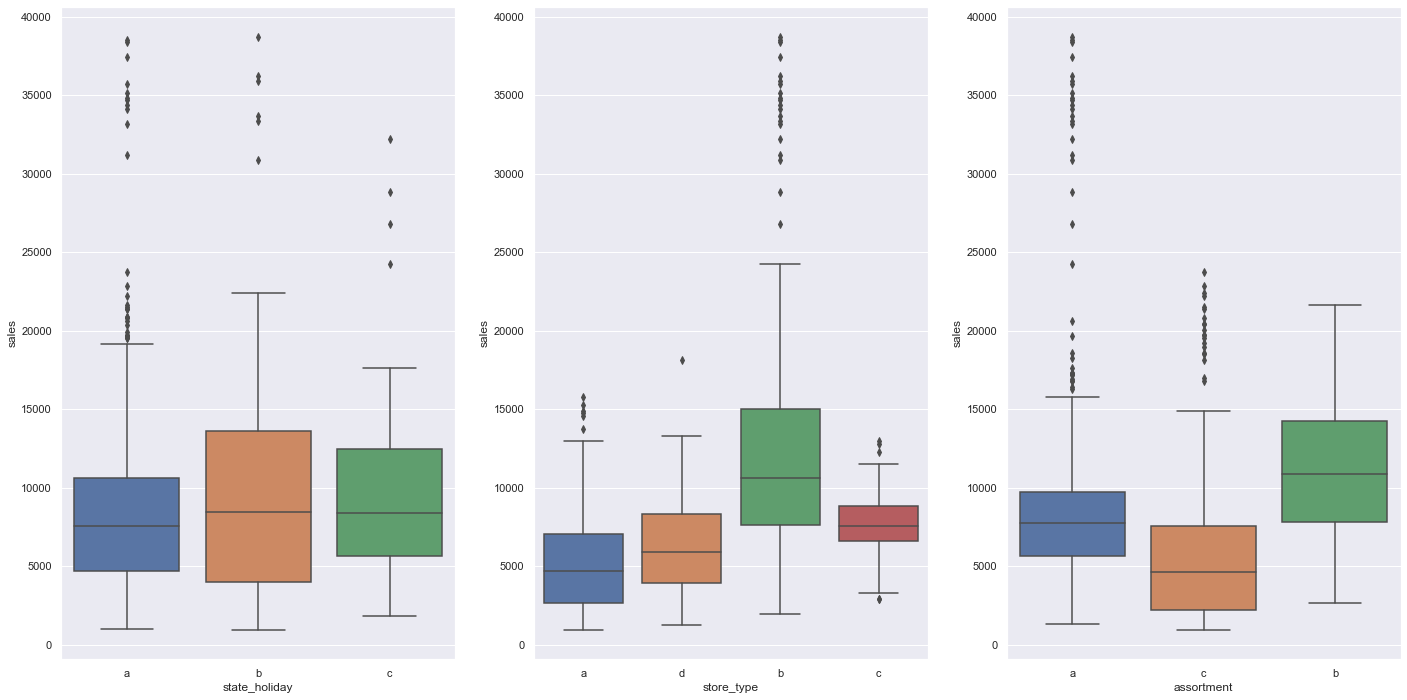

In [16]:
aux1 = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )]

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0. FEATURE ENGINEERING

In [17]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

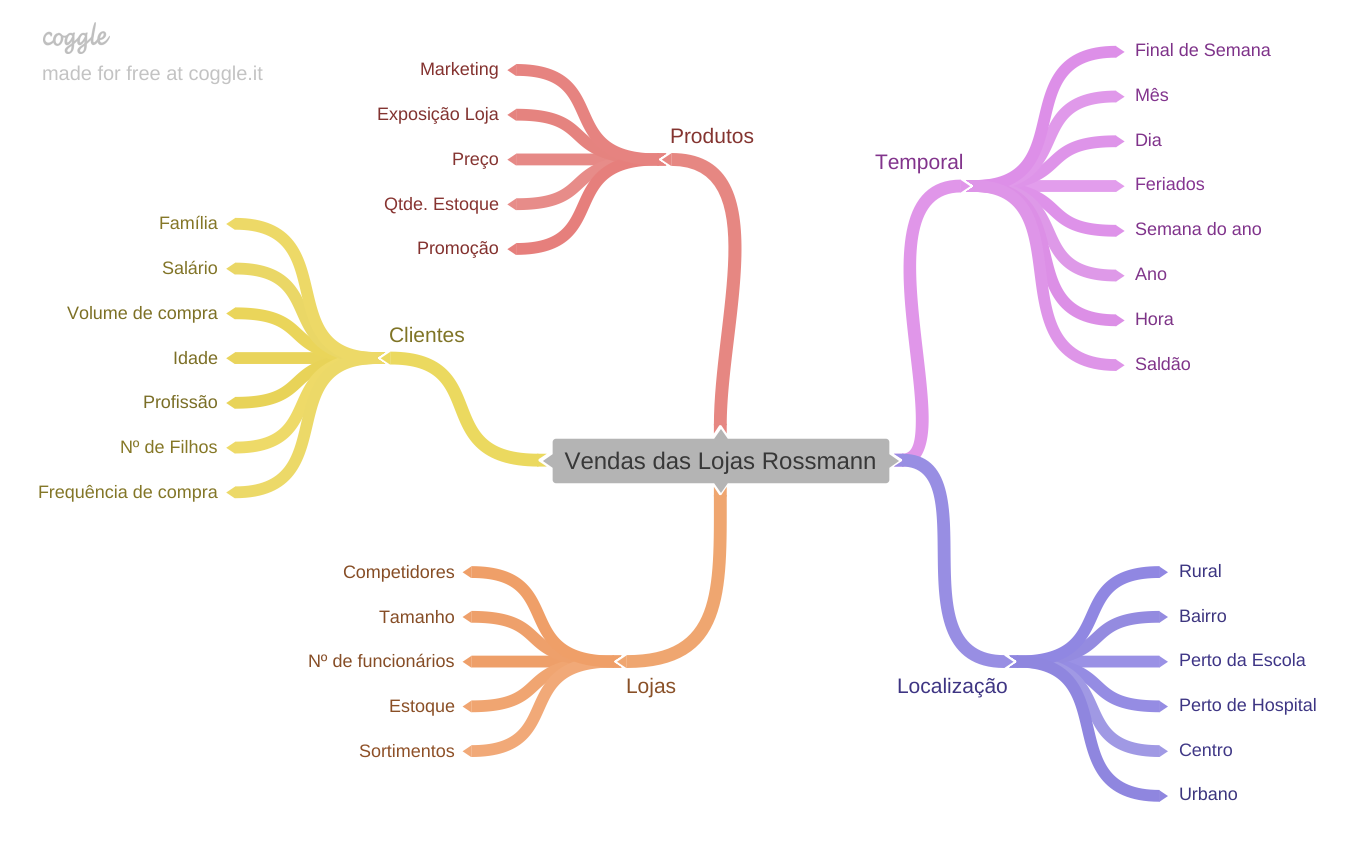

In [18]:
Image( 'img/Vendas_das_Lojas_Rossmann.png' )

## 2.2. Criação das Hipóteses

### 2.2.1. Hipóteses Lojas

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [19]:
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# Competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'] , month=x['competition_open_since_month'] , day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( 'int64' )

# Promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( 'int64' )

# Assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended' )

# State holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day' )


# 3.0. FILTRAGEM DE VARIÁVEIS

In [20]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [21]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2. Seleção das Colunas

In [22]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0. ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)

In [23]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Variável Resposta

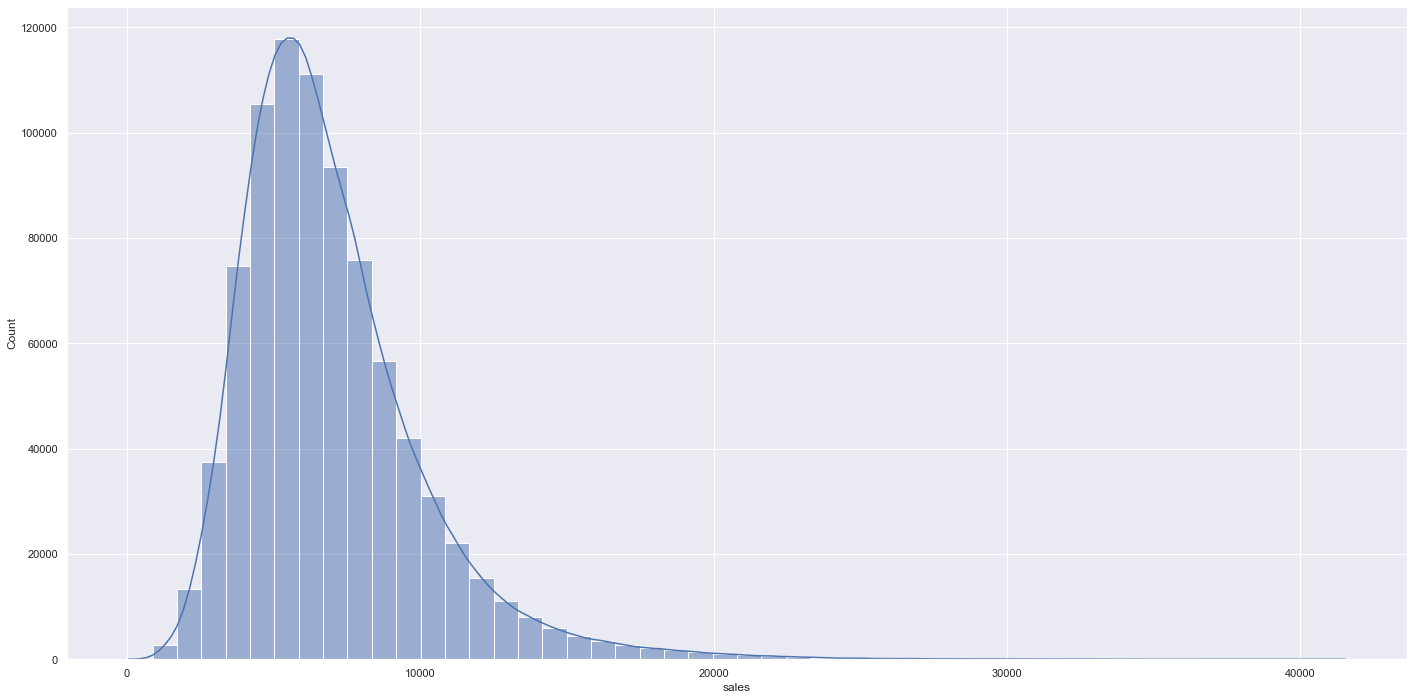

In [24]:
sns.histplot( x = df4['sales'], bins=50, kde=True );

### 4.1.2. Variável Numérica

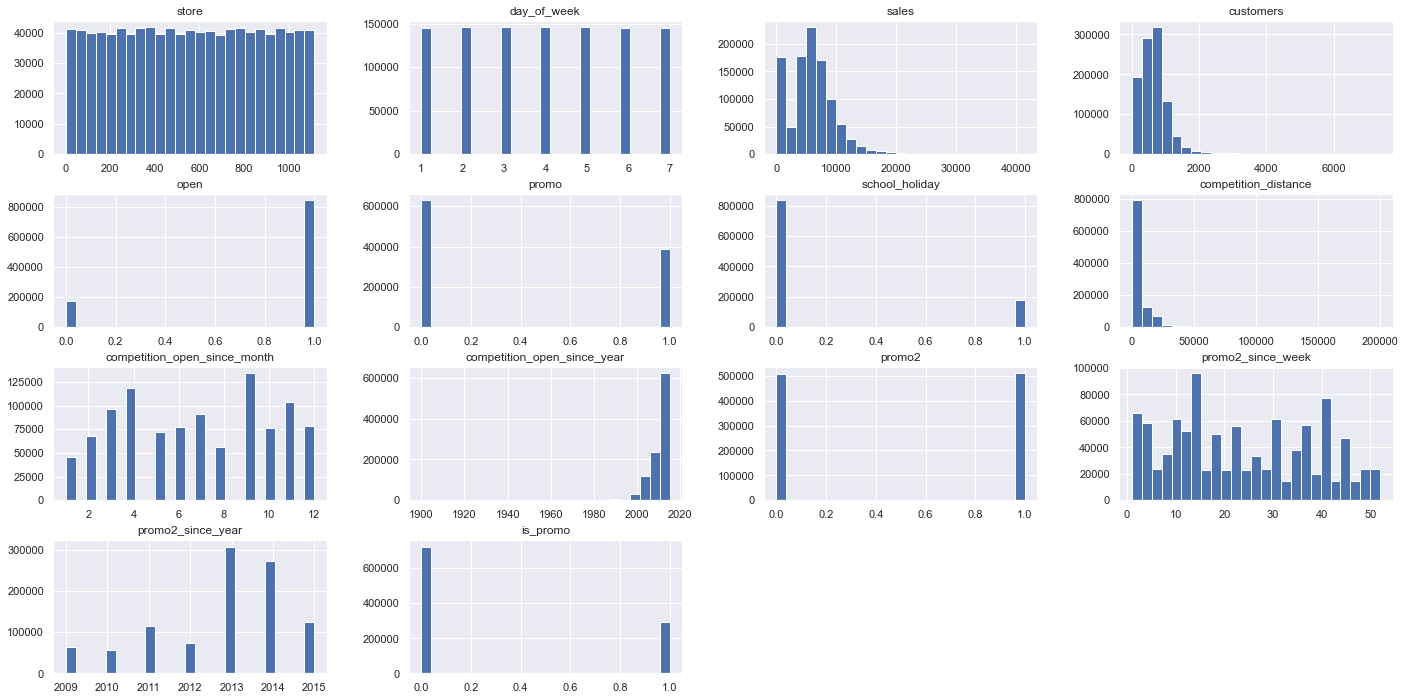

In [25]:
num_attributes.hist( bins=25 );

### 4.1.3. Variável Categórica

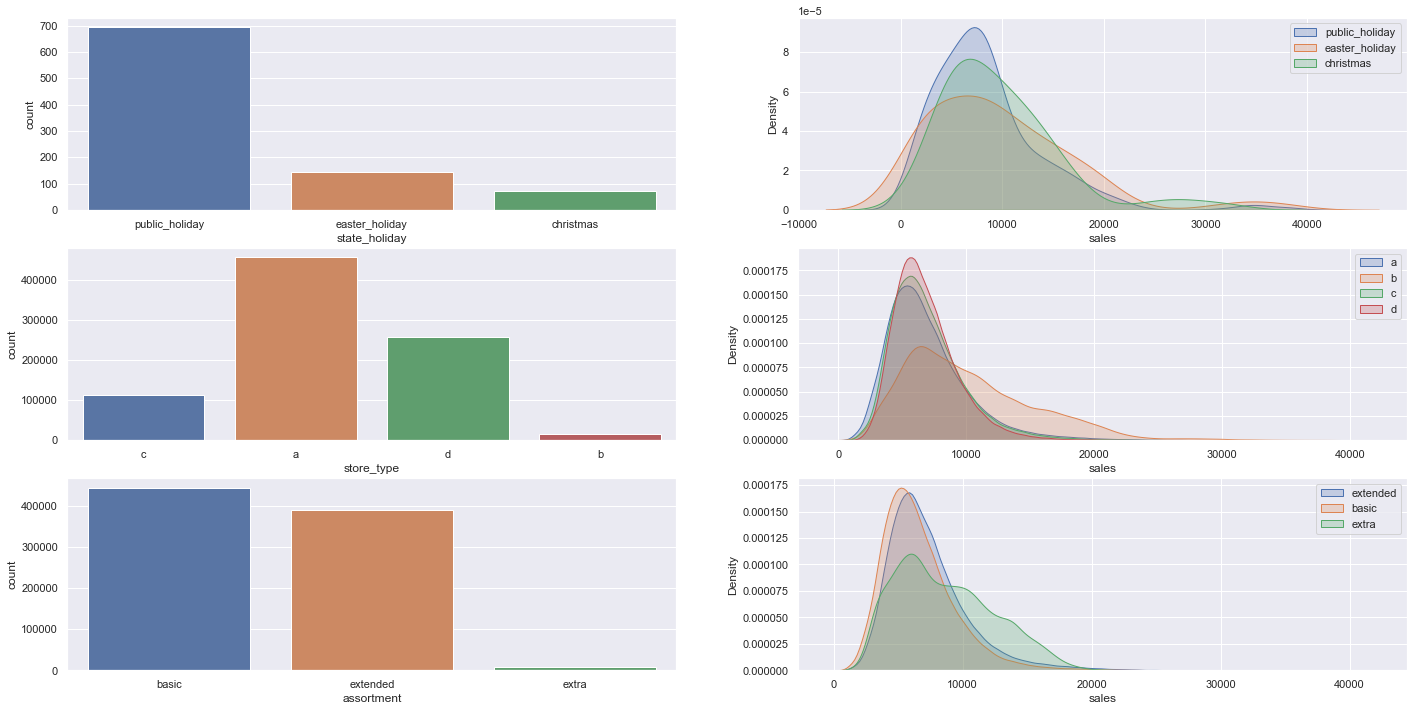

In [26]:
# state_holiday
plt.subplot( 3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( x=a['state_holiday'] )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )
plt.legend()

# store_type
plt.subplot( 3, 2, 3)
sns.countplot( x=df4['store_type'] )

plt.subplot( 3, 2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )
plt.legend()

# assortment
plt.subplot( 3, 2, 5)
sns.countplot( x=df4['assortment'] )

plt.subplot( 3, 2, 6)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )
plt.legend()

## 4.2. Análise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.
**FALSA** - Lojas com MAIOR SORTIMENTOS vendem MENOS

<AxesSubplot:xlabel='year_week'>

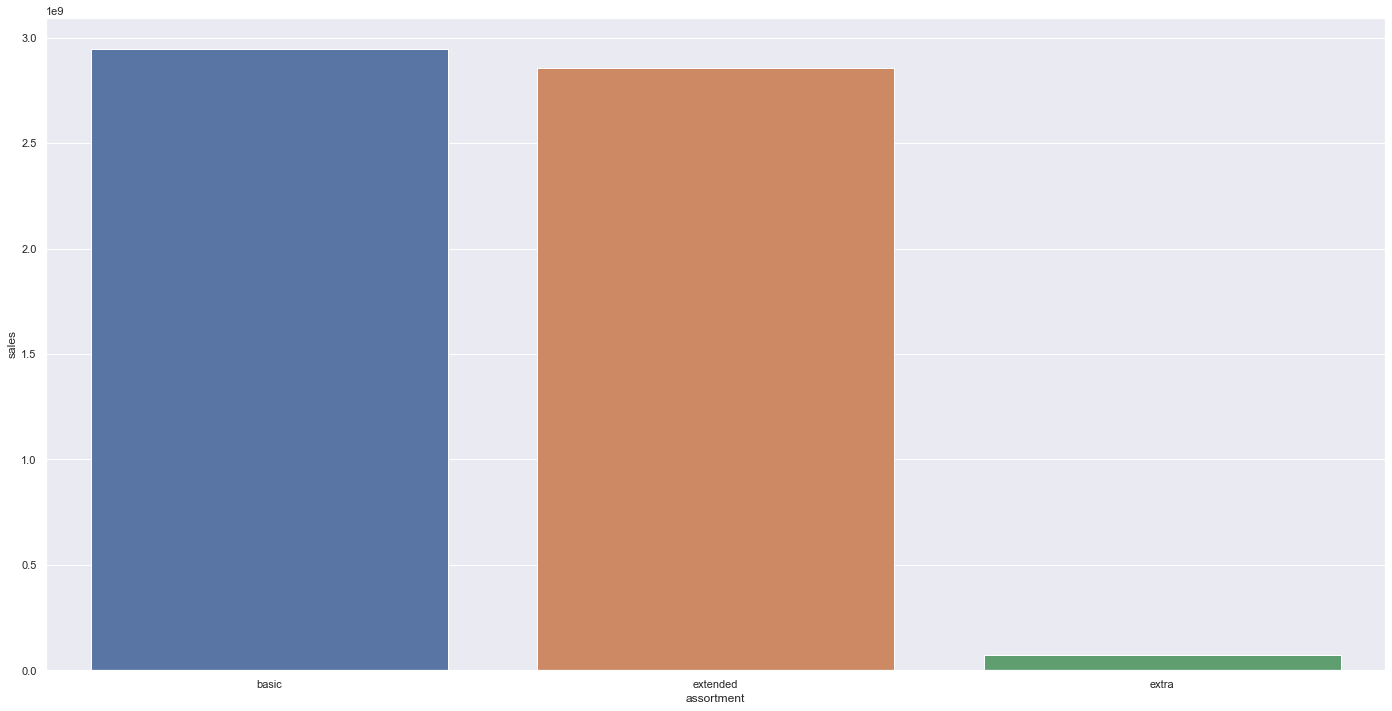

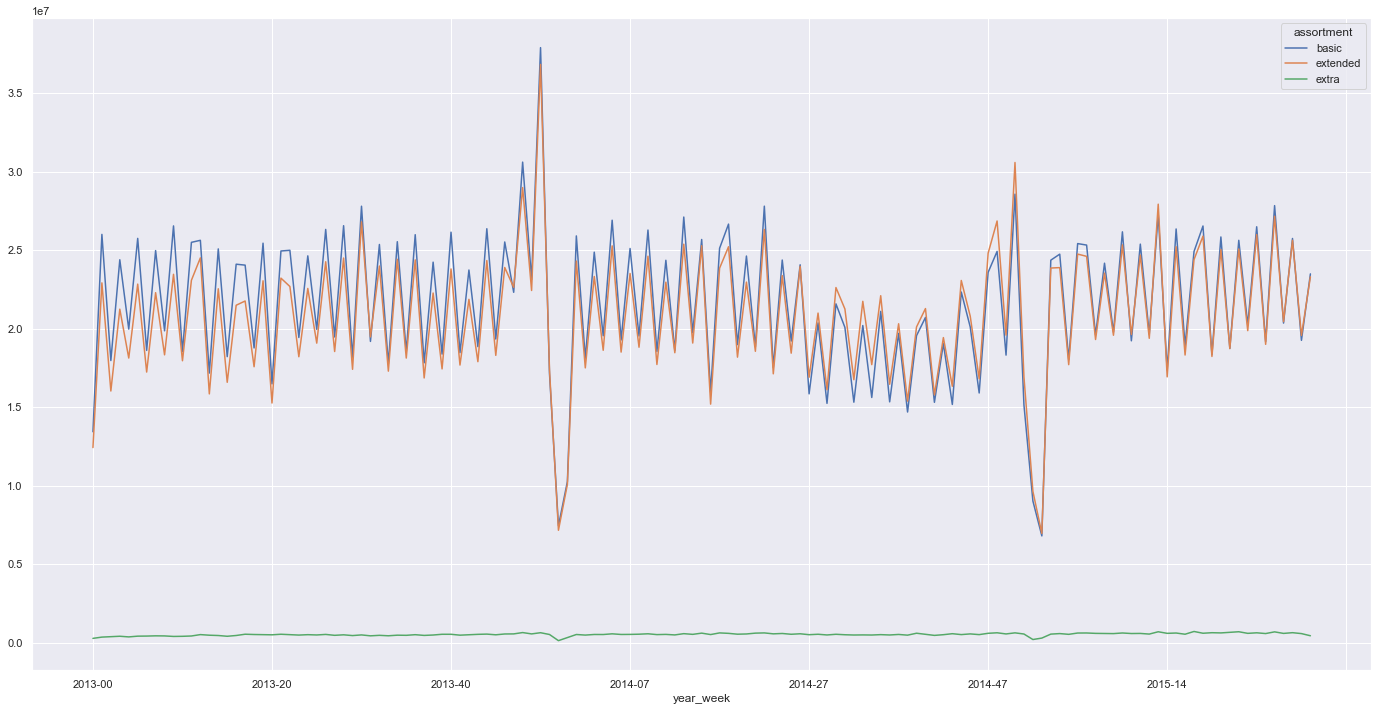

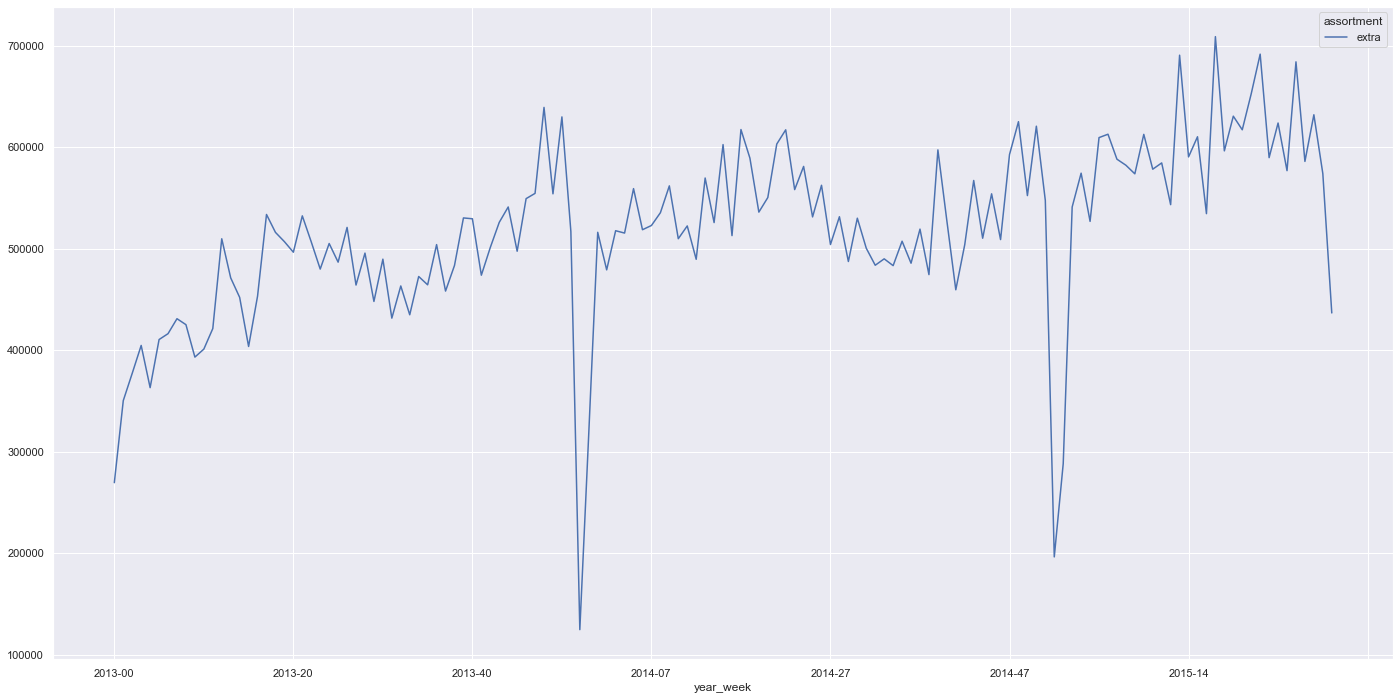

In [27]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** - Lojas com competidores MAIS próximos vendem MAIS.

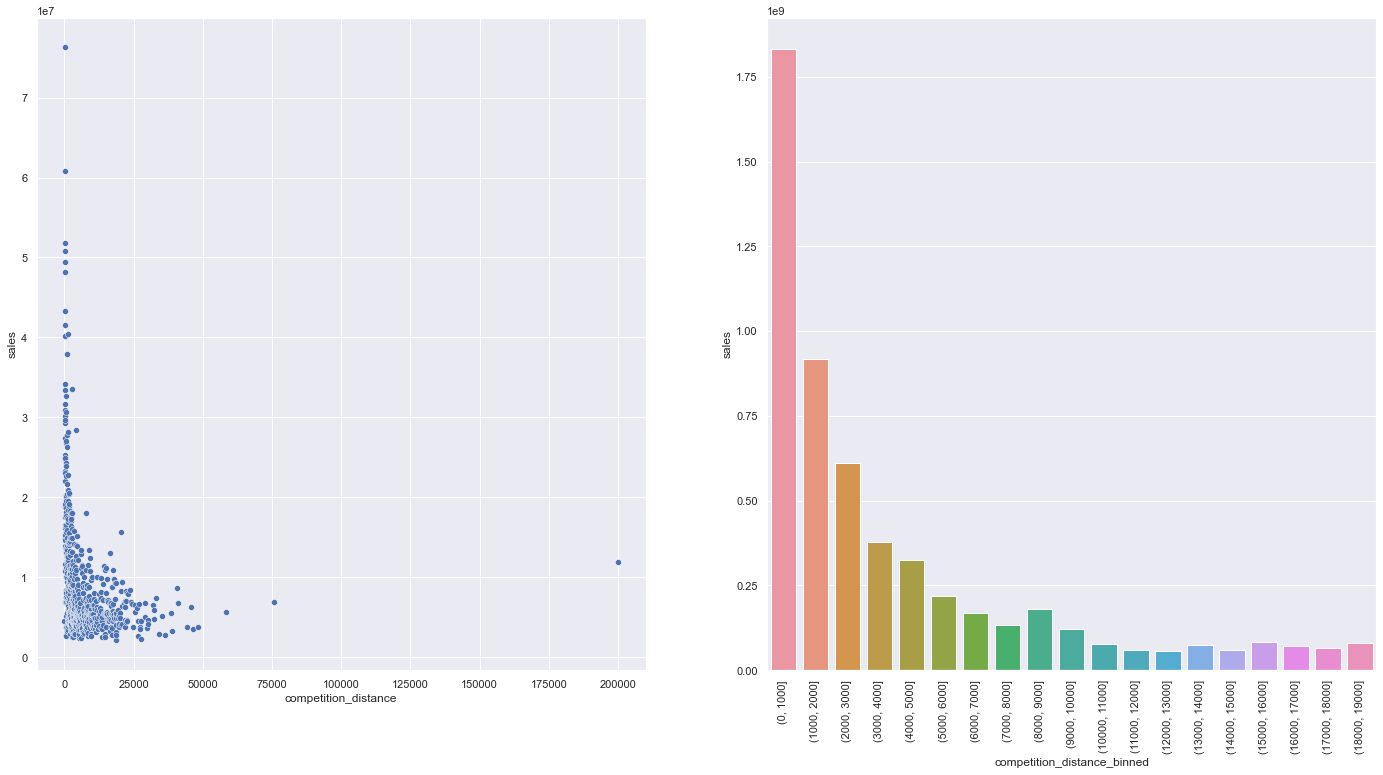

In [28]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 2, 1 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1 )

plt.subplot( 1, 2, 2 )
bins = list( np.arange( 0, 20000, 1000 ) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 )
plt.xticks(rotation=90);

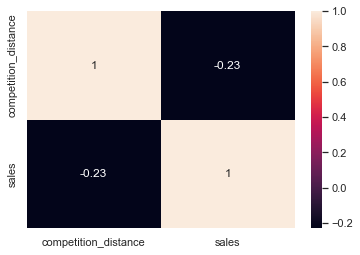

In [29]:
plt.figure(figsize=(6,4))
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H3. Lojas com competidores à mais tempo deveriam vendem mais.
**FALSA** - Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

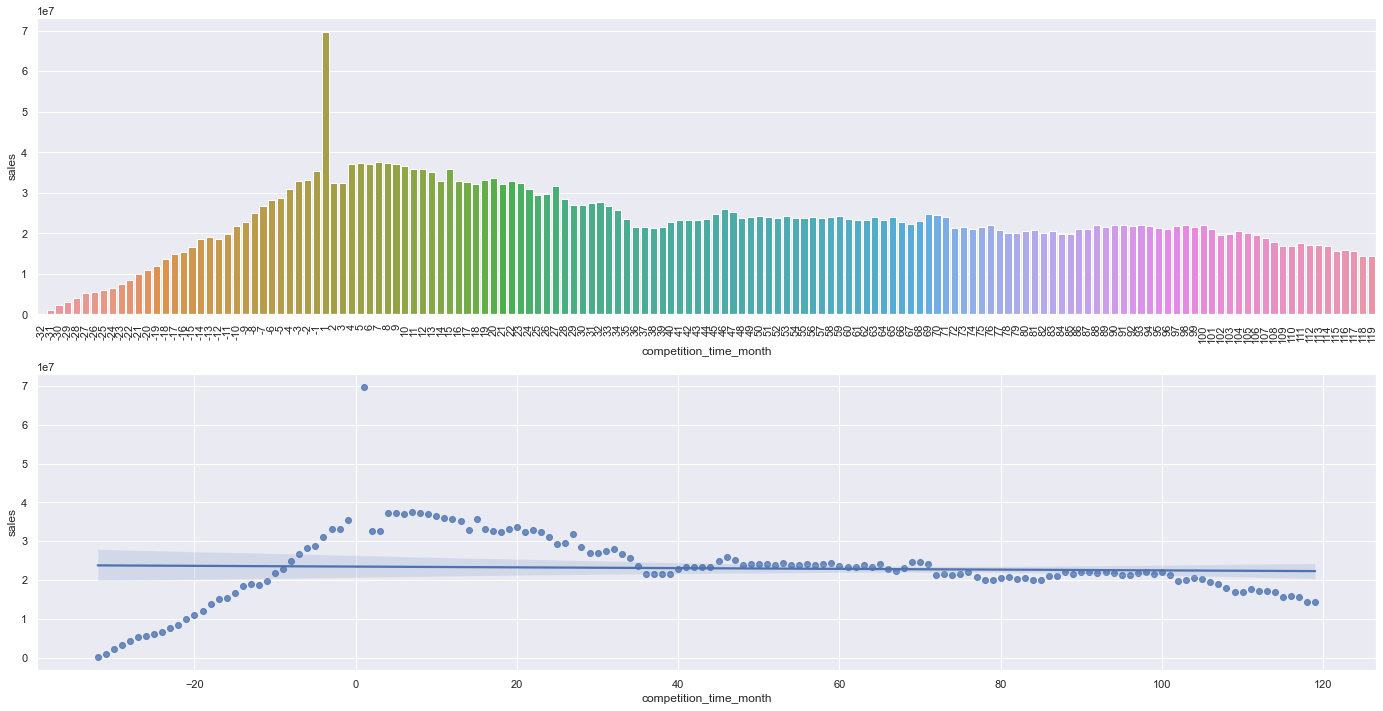

In [30]:
plt.subplot(2,1,1)
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] !=0 )] #Filtra os 120 primeiros meses de competição e tempo de competição igual a zero (abriu no mesmo mês da venda)
sns.barplot( x='competition_time_month', y='sales', data=aux2 )
plt.xticks( rotation= 90);

plt.subplot(2,1,2)
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

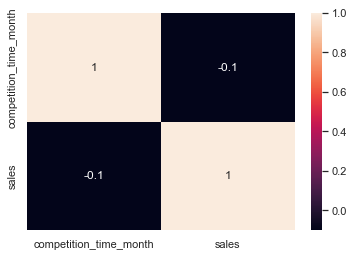

In [31]:
plt.figure(figsize=(6,4))
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** - Lojas com PROMOÇÕES ATIVAS por mais tempo vendem MENOS, depois de um certo período de promoção.

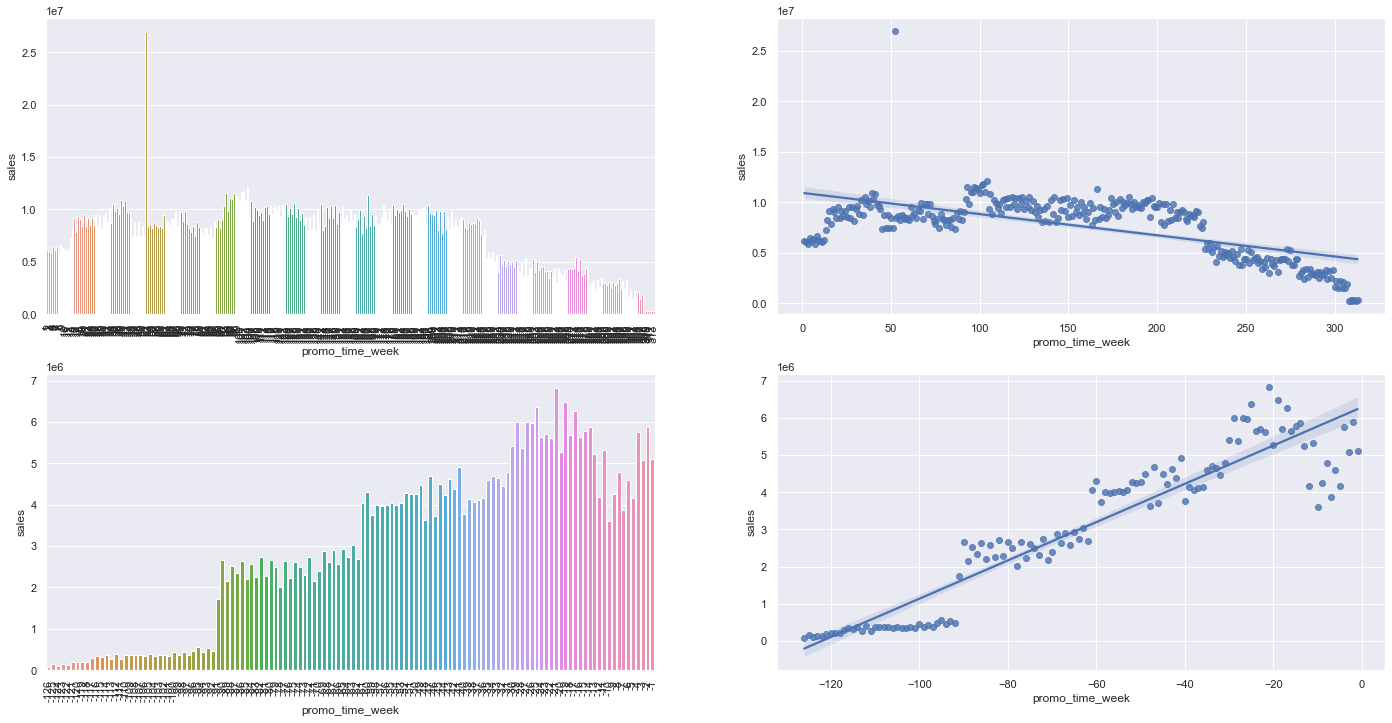

In [32]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

# Quebra do dataset para melhor visualização
# parte1 - promo extendida
plt.subplot(2,2,1)
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(2,2,2)
sns.regplot(x='promo_time_week', y='sales', data=aux2)

# parte2 - promo regular
plt.subplot(2,2,3)
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90);

plt.subplot(2,2,4)
sns.regplot(x='promo_time_week', y='sales', data=aux3);

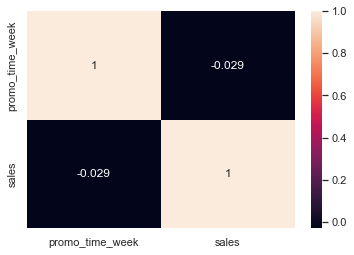

In [33]:
plt.figure(figsize=(6,4))
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s> H5. Lojas com mais dias de promoção deveriam vender mais. </s>



### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** - Loja com MAIS promoções CONSECUTIVAS vendem MENOS.

In [34]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


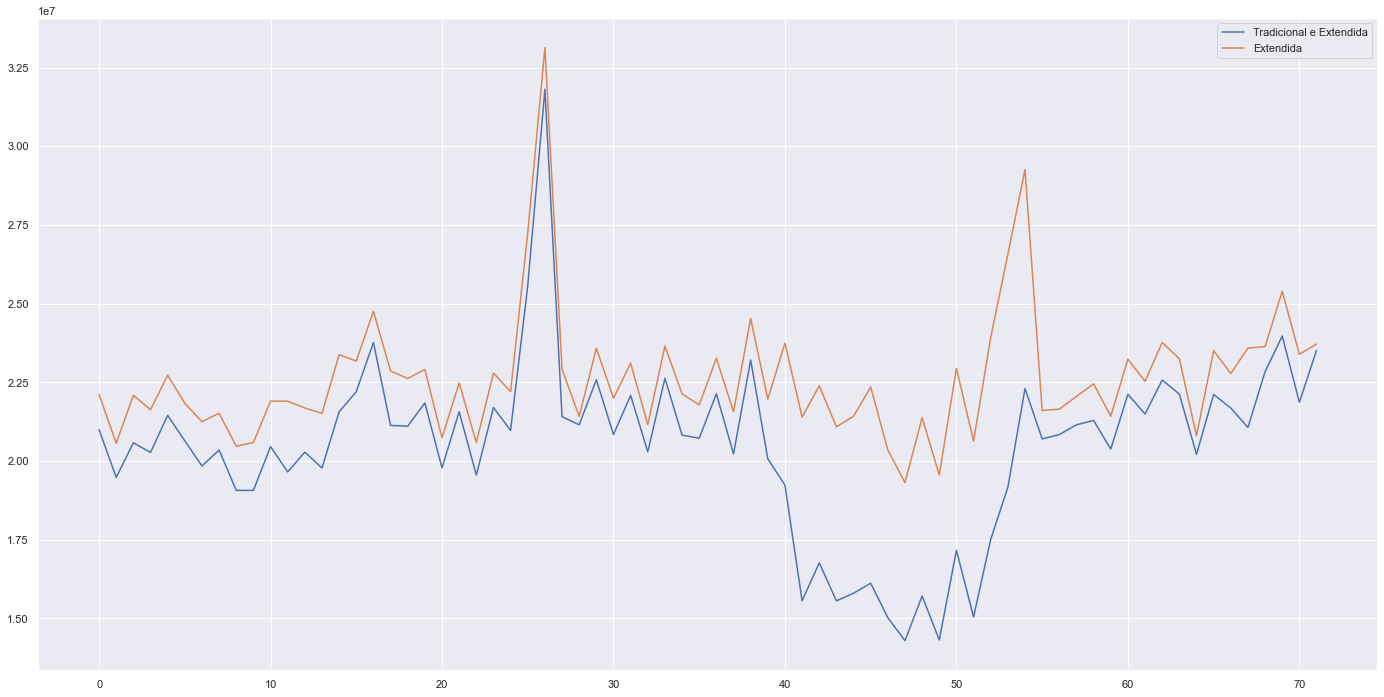

In [35]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendida', 'Extendida']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** - Lojas abertas durante o feriado de NATAL vendem MENOS.

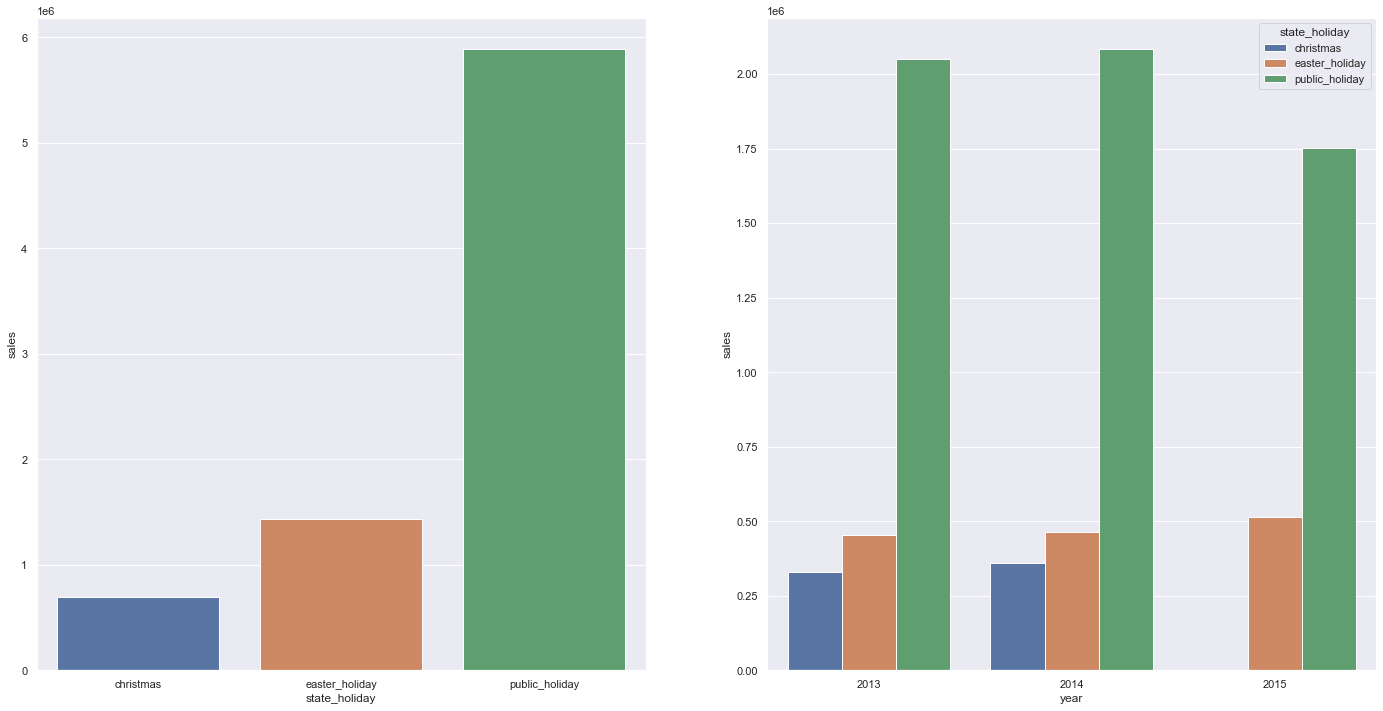

In [36]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSA** - Lojas vendem MENOS ao longo dos anos.

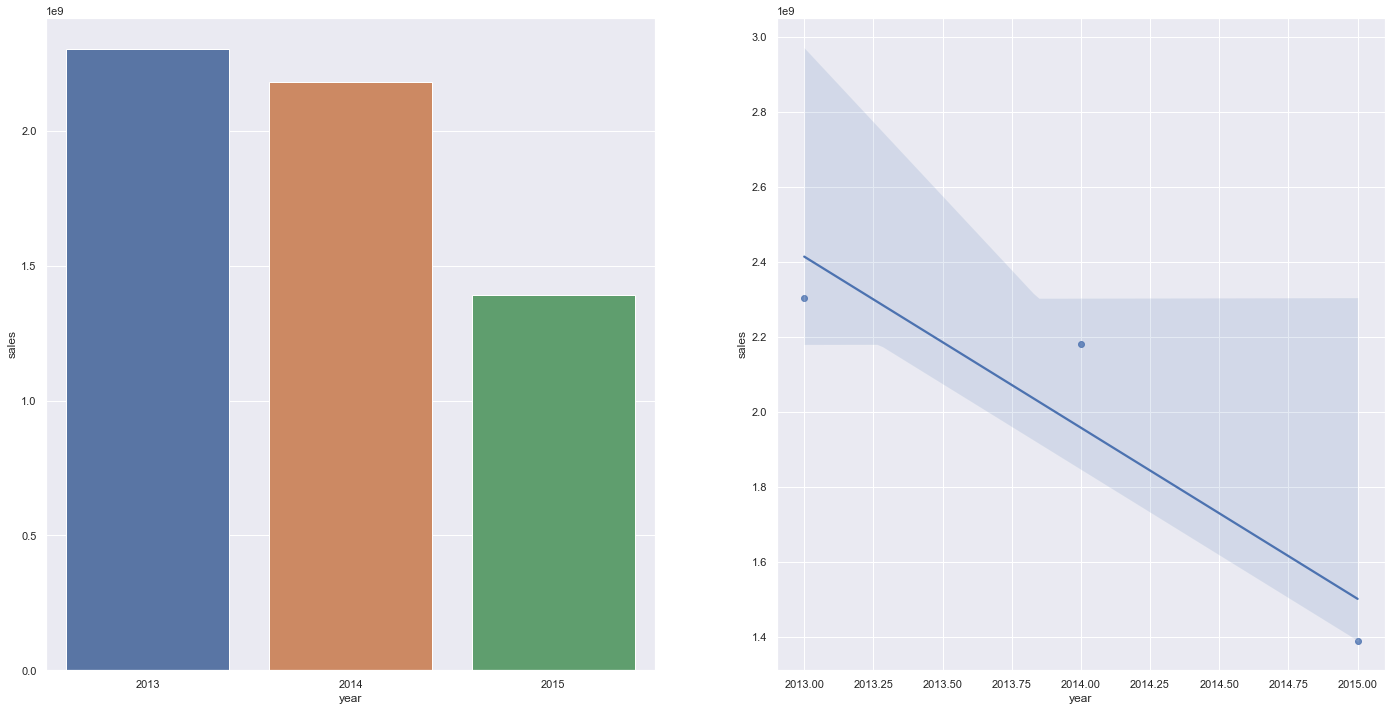

In [37]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,2,2)
sns.regplot(x='year', y='sales', data=aux1);

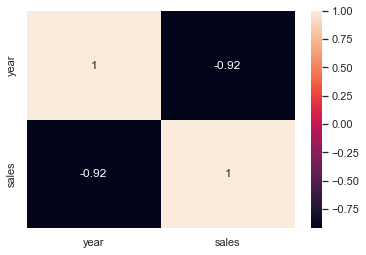

In [38]:
plt.figure(figsize=(6,4))
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H9. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** - Lojas vendem MENOS no SEGUNDO SEMESTRE do ano.

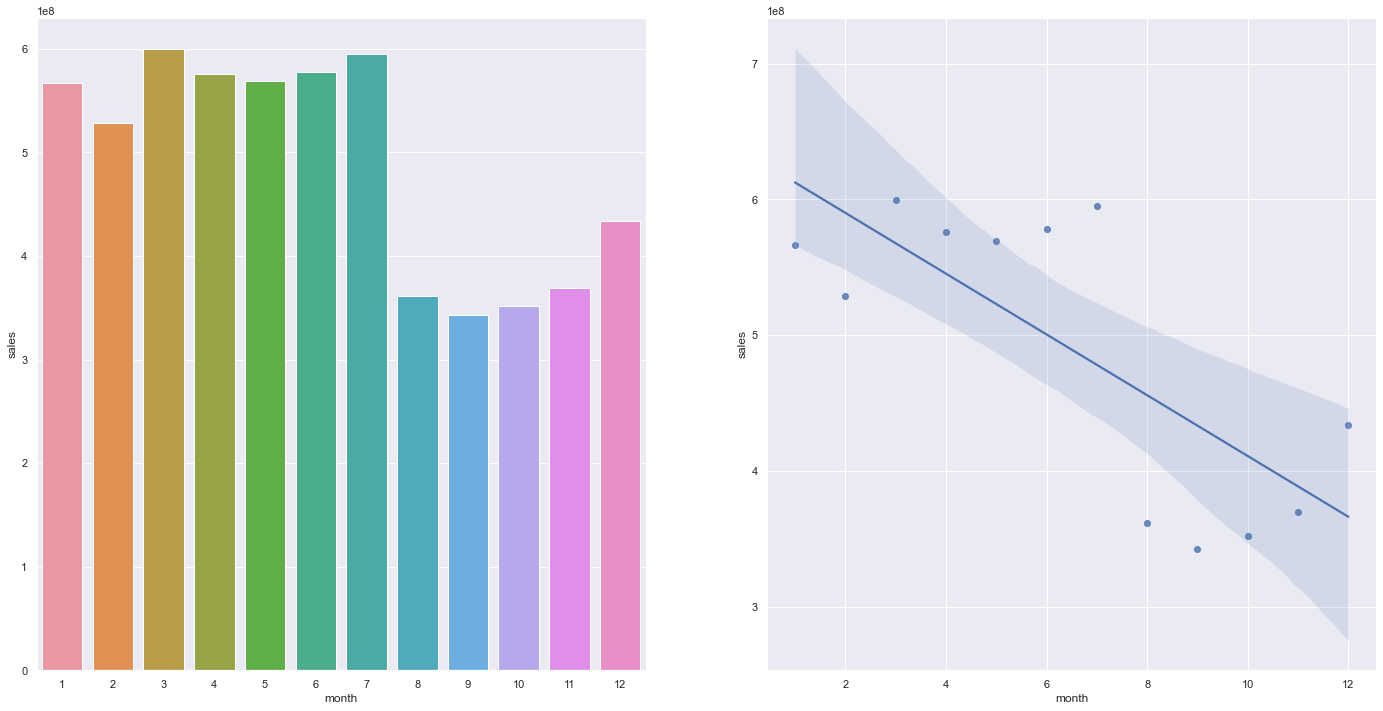

In [39]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,2,2)
sns.regplot(x='month', y='sales', data=aux1);

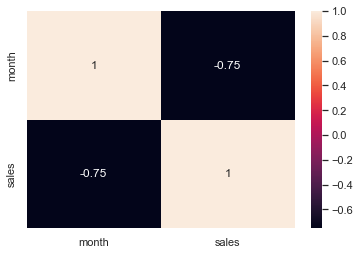

In [40]:
plt.figure(figsize=(6,4))
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** - Lojas VENDEM MAIS depois do dia 10 de cada mês.

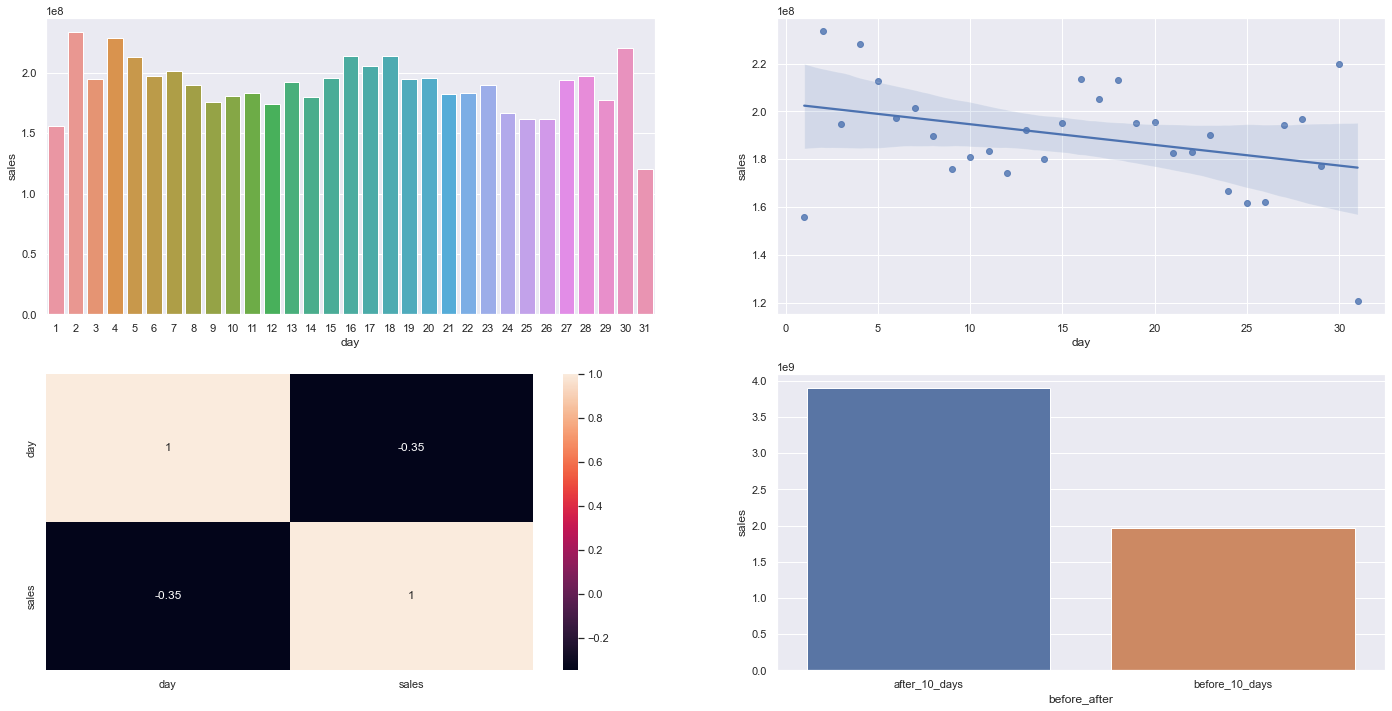

In [41]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap( aux1.corr(method='pearson'), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);

### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** - Lojas VENDEM MENOS aos finais de semana.

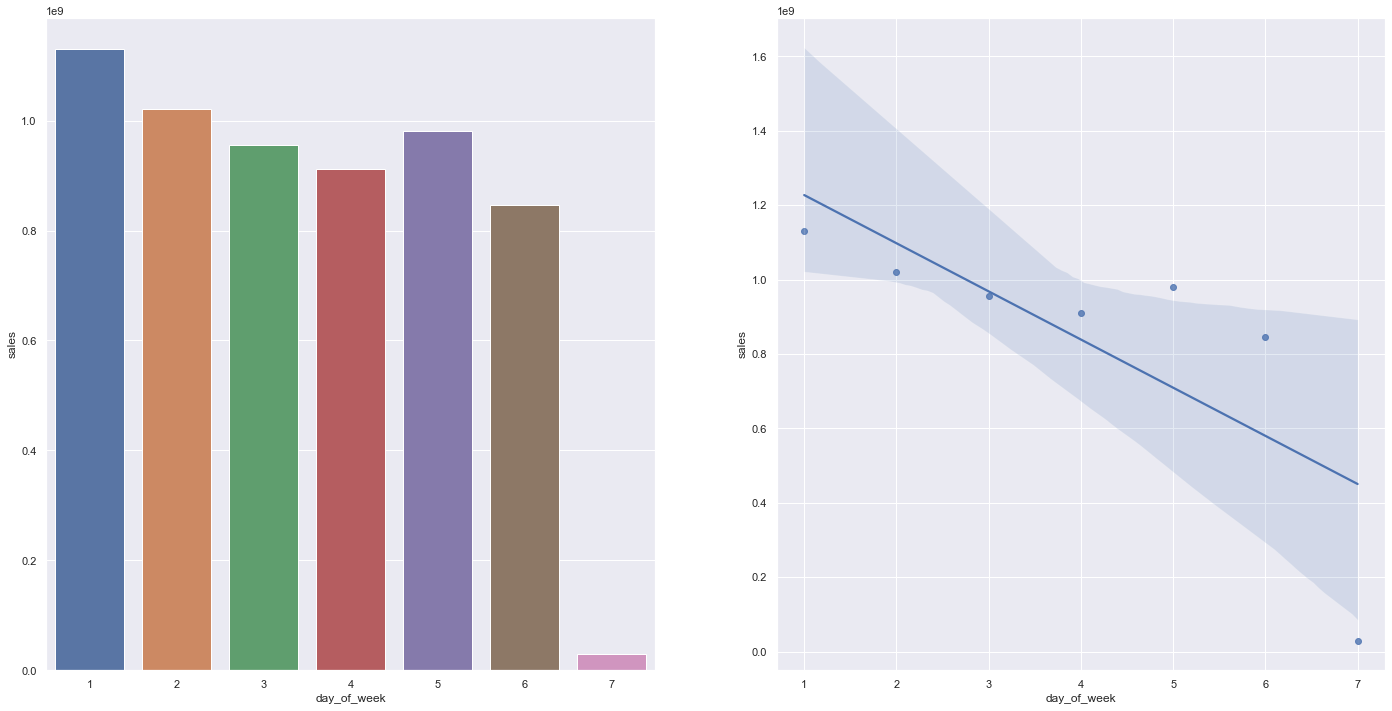

In [42]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,2,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

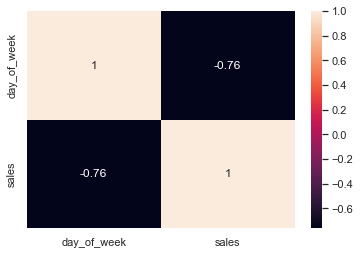

In [43]:
plt.figure(figsize=(6,4))
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H12. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** - Lojas VENDEM MENOS durante os feriados escolares.

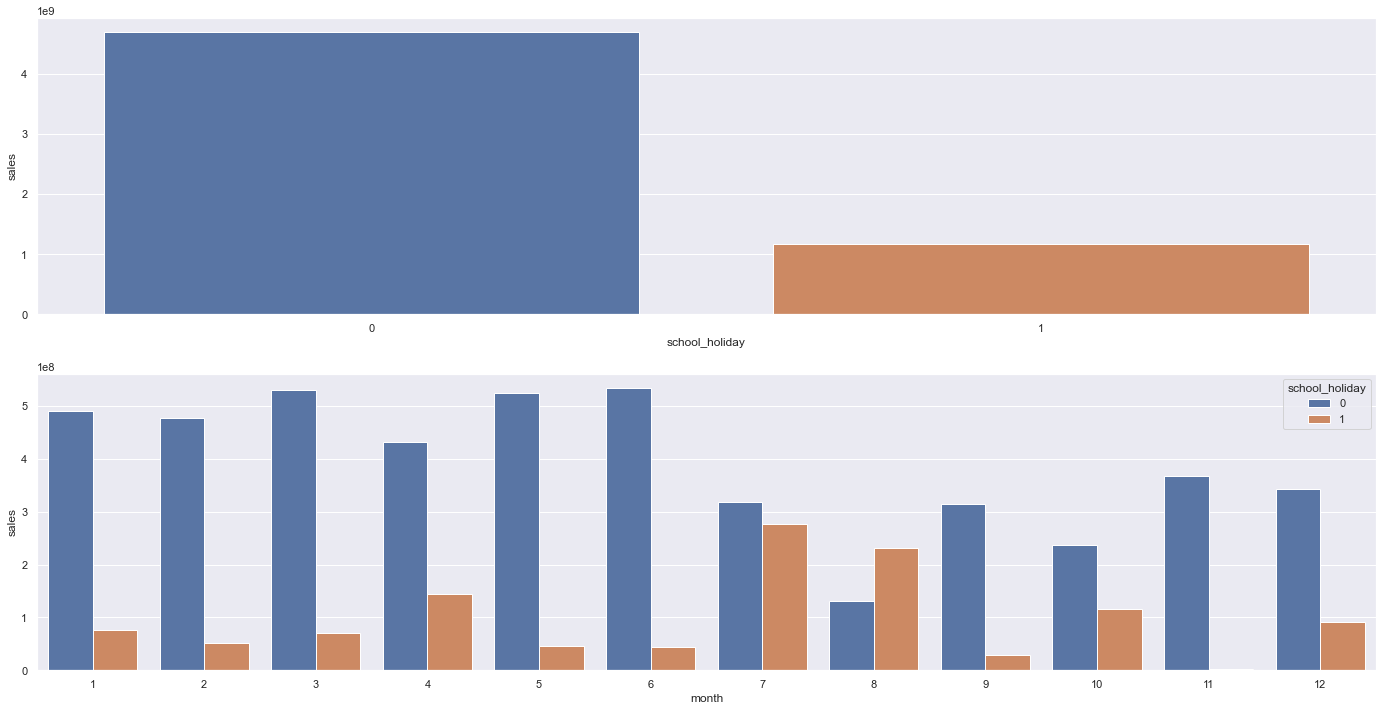

In [44]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

# Visualizando as vendas durante os feriados escolares agrupados pelo mês
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

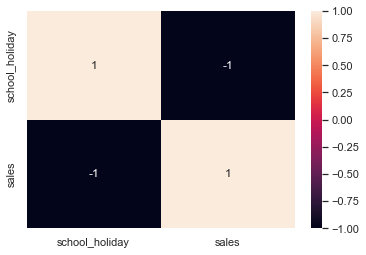

In [45]:
plt.figure(figsize=(6,4))
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 4.2.1 Resumo das Hipóteses

In [46]:
tab = [['HIPÓTESES', 'CONCLUSÃO', 'RELEVÂNCIA'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Média'],
       ['H3', 'Falsa', 'Média'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Média'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Baixa'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Alta']
      ]
print( tabulate( tab, headers='firstrow', tablefmt="fancy_grid" ) )

╒═════════════╤═════════════╤══════════════╕
│ HIPÓTESES   │ CONCLUSÃO   │ RELEVÂNCIA   │
╞═════════════╪═════════════╪══════════════╡
│ H1          │ Falsa       │ Baixa        │
├─────────────┼─────────────┼──────────────┤
│ H2          │ Falsa       │ Média        │
├─────────────┼─────────────┼──────────────┤
│ H3          │ Falsa       │ Média        │
├─────────────┼─────────────┼──────────────┤
│ H4          │ Falsa       │ Baixa        │
├─────────────┼─────────────┼──────────────┤
│ H5          │ -           │ -            │
├─────────────┼─────────────┼──────────────┤
│ H6          │ Falsa       │ Baixa        │
├─────────────┼─────────────┼──────────────┤
│ H7          │ Falsa       │ Média        │
├─────────────┼─────────────┼──────────────┤
│ H8          │ Falsa       │ Alta         │
├─────────────┼─────────────┼──────────────┤
│ H9          │ Falsa       │ Alta         │
├─────────────┼─────────────┼──────────────┤
│ H10         │ Verdadeira  │ Baixa        │
├─────────

## 4.3. Análise Multivariada

### 4.3.1. Correlação Atributos Numéricos

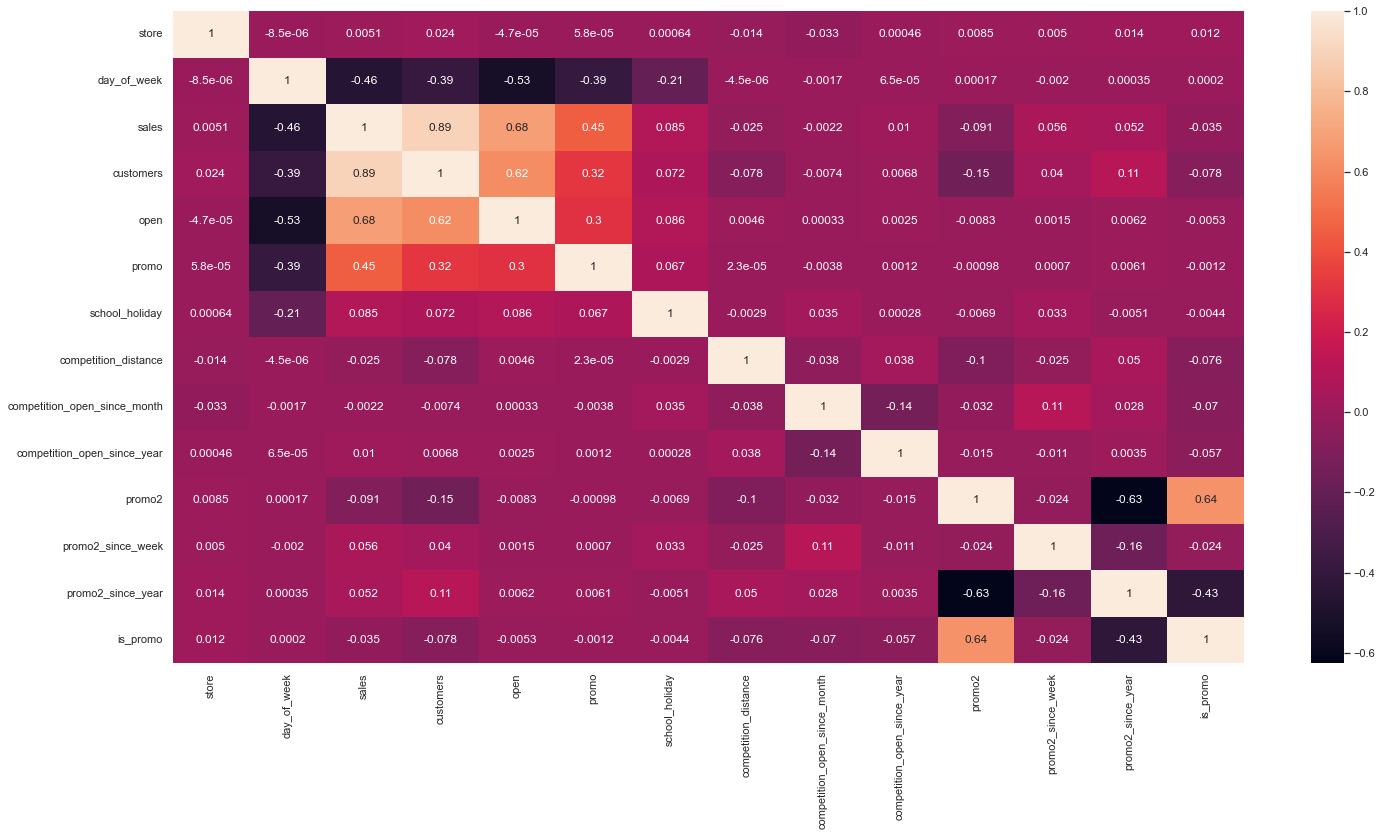

In [47]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2. Correlação Atributos Categóricos

<AxesSubplot:>

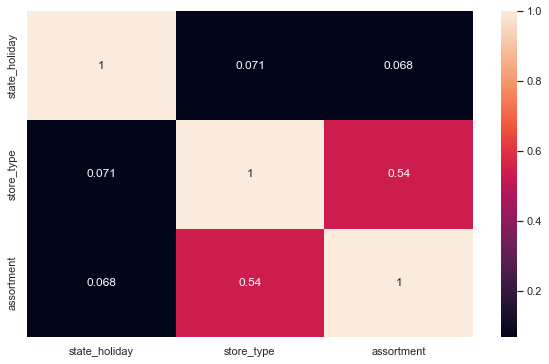

In [48]:
# seleciona os atributos categóricos
cat = df4.select_dtypes( include=['object'] )

# aplica a função crame_v
a1 = cramer_v( cat['state_holiday'], cat['state_holiday'] )
a2 = cramer_v( cat['state_holiday'], cat['store_type'] )
a3 = cramer_v( cat['state_holiday'], cat['assortment'] )

a4 = cramer_v( cat['store_type'], cat['state_holiday'] )
a5 = cramer_v( cat['store_type'], cat['store_type'] )
a6 = cramer_v( cat['store_type'], cat['assortment'] )

a7 = cramer_v( cat['assortment'], cat['state_holiday'] )
a8 = cramer_v( cat['assortment'], cat['store_type'] )
a9 = cramer_v( cat['assortment'], cat['assortment'] )

# transforma os valores em um dataframe
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9] } )
d = d.set_index( d.columns )

# plota o heatmap
plt.figure( figsize=(10, 6) )
sns.heatmap( d, annot=True )

# 5.0. PREPARAÇÃO DOS DADOS

In [49]:
df5 = df4.copy()

## 5.1. Normalização
- Consultando a seção 4.1.2 verificamos que as variáveis não possuem distribuição normal. Portanto não será aplicado o método de normalização.

## 5.2. Rescaling

In [50]:
x = df5.select_dtypes( include=['int64', 'float64'] )

Selecionamos as variáveis (de natureza cíclica) que vamos aplicar o Rescaling:
- competition distance
- competition time month
- promo time week
- year

Verificamos os outlier dessas variáveis para saber qual técnica será utilizada, MinMaxScaler ou RobustScaler.

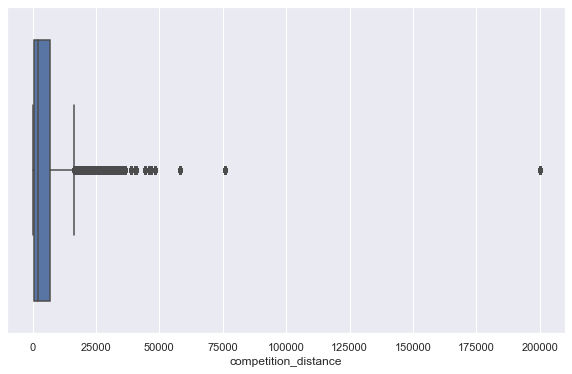

In [51]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['competition_distance']);

Como podemos observar **competition_distance** tem outliers bem definidos, dessa forma devemos utilizar a técnica de RobustScaler;

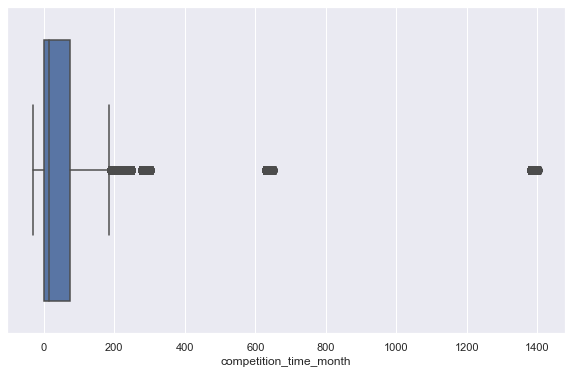

In [52]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['competition_time_month']);

Como podemos observar **competition_time_month** também tem seus outliers definidos, dessa forma utilizaremos a RobustScaler;

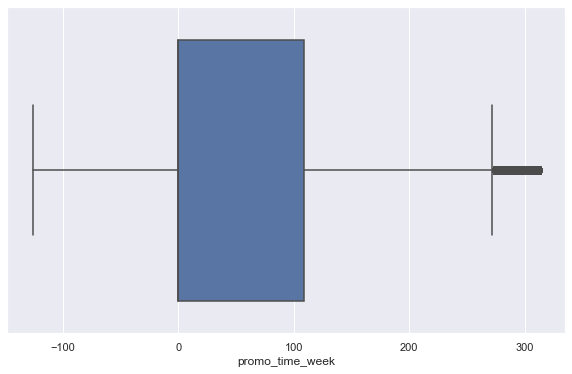

In [53]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['promo_time_week']);

Observamos que **promo_time_week** não possue outiliers tão relevantes, assim vamos arriscar usar a MinMaxScaler;

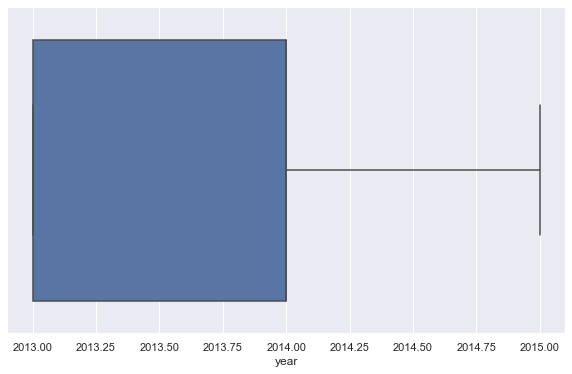

In [54]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['year']);

Já **year** nitidamente não possue outliers, desta forma usaremos a MinMaxScaler.

In [55]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

## 5.3. Transformação

### 5.3.1. Encoding

In [56]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( data=df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Tranformação de Natureza

In [57]:
# Transformação Seno e Cosseno
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(np.pi/7)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(np.pi/52)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(np.pi/30)))

### 5.3.3. Tranformação Variável Resposta

In [58]:
df5['sales'] = np.log1p( df5['sales'] ) #logarithm

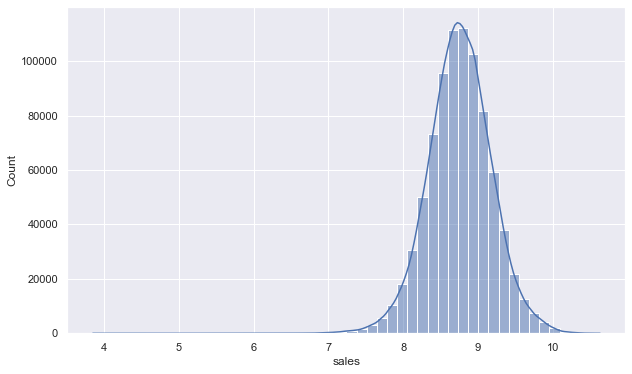

In [59]:
plt.figure( figsize=(10,6) )
sns.histplot(x = df5['sales'], bins=50, kde = True);

# 6.0. SELEÇÃO DE VARIÁVEIS

In [60]:
df6 = df5.copy()

## 6.1. Split Dataframe

In [61]:
# Deletar colunas que foram transformadas no passo 5.0
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

Para separar o dataframe em treino e teste, vamos considerar as últimas 6 semanas como o conjunto de treinamento e o restante como teste.

In [62]:
# Verificar a data inicial das vendas
df6[['store', 'date']].groupby('store').min().reset_index()['date'][0]

Timestamp('2013-01-02 00:00:00')

In [63]:
# Verificar a data final das vendas
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0]

Timestamp('2015-07-31 00:00:00')

Nesse conjunto de dados observamos que o período de vendas está entre 02-01-2013 e 31-07-2015.

In [64]:
#Agora vamos subtrair as 6 semanas da data final 31-07-2015.
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

Agora que temos a data de quando começou as últimas 6 semanas, vamos usá-la como referência na separação entre treinamento e teste.

In [65]:
# trainning dataset
# os dados de treinamento serão todos aqueles que antecedem a data de 19-06-2015.
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
# os dados de treinamento serão todos aqueles que se iniciam na data 19-06-2015 até o último dia de vendas 31-07-2015.
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Seleção de Features BORUTA

In [73]:
# training and test dataset for vetor Boruta
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

# definição do modelo utilizado RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

# definição boruta
bortuta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	17
Tentative: 	2
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	17
Tentative: 	2
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	17
Tentative: 	2
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	17
Tentative: 	2
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	17
Tentative: 	2
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	17
Tentative: 	2
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	17
Tentative: 	2
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	17
Tentative: 	2
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	17
Tentative: 	2
Rejected: 	8
I

KeyboardInterrupt: 

### 6.2.1. Melhores Features selecionadas pelo BORUTA

In [ ]:
cols_selected = boruta.support_.tolist()

# Selecionadas
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 ) #Cria uma nova variável em formato dataframe para utilizar no cols_selected_boruta sem as colunas date e sales
cols_selected_boruta = X_train_fs.iloc[:, cols_selected ].columns.to_list() # Seleciona somente os nomes das colunas e transforma em lista

# Não Selecionadas
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) ) # Mostra a diferença entre o original e as selecionadas

In [ ]:
cols_selected_boruta

In [ ]:
cols_not_selected_boruta

## 6.3. Seleção de Features MANUAL

In [84]:
# add 'month_sin' e 'week_of_year_sin', que o boruta não selecionou, mas que vamos utilizar.
cols_selected_boruta = ['store','promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                                   'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                                   'promo_time_week','month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin','week_of_year_cos', 
                                   'day_of_week_sin', 'day_of_week_cos']

## columns to add
#feat_to_add = ['date', 'sales']
#
## final features
#cols_selected_boruta.extend( feat_to_add )

# 7.0. MODELOS DE MACHINE LEARNING 

In [85]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1. Average

In [86]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns={'sales':'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression

In [87]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1868.126202,0.294635,2661.840827


## 7.3. Regularized Linear Regression

In [88]:
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1897.325175,0.28957,2750.434994
